In [ ]:
!git clone https://gitlab.dognosis.link/pub/dogos-quest

fatal: destination path 'dogos-quest' already exists and is not an empty directory.


In [ ]:
!pip install mne
!pip install numpy
!pip install pandas
!pip install pathlib
!pip install asrpy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
from asrpy import ASR


# 1. loading EEG and Calibration Data
eeg_file = '/content/dogos-quest/quest_eeg/060924-1700/Explore_84CF_ExG_ExG_stream_3.csv'
cal_file = '/content/dogos-quest/quest_eeg/060924-1700/calibration_exg.csv'
marker_file = '/content/dogos-quest/quest_eeg/060924-1700/Explore_84CF_Marker_Markers_stream_1.csv'

df_eeg = pd.read_csv(eeg_file)
df_cal = pd.read_csv(cal_file)
df_markers = pd.read_csv(marker_file)

# labeling
labels = ['Ch_1','Ch_2','Ch_3','Ch_4','Ch_5','Ch_6','Ch_7','Ch_8']
df_eeg.columns = ['Timestamps'] + labels
df_cal.columns = ['Timestamps'] + labels


# 2. Preparing Calibration Data for ASR
sfreq = 1000.0
cal_data = df_cal[labels].values.T
eeg_data = df_eeg[labels].values.T

info = mne.create_info(ch_names=labels, ch_types=['eeg']*len(labels), sfreq=sfreq)
raw_cal = mne.io.RawArray(cal_data, info)
raw_eeg = mne.io.RawArray(eeg_data, info)




Creating RawArray with float64 data, n_channels=8, n_times=103025
    Range : 0 ... 103024 =      0.000 ...   103.024 secs
Ready.
Creating RawArray with float64 data, n_channels=8, n_times=366512
    Range : 0 ... 366511 =      0.000 ...   366.511 secs
Ready.


In [ ]:

# 3. ASR applied
asr = ASR(sfreq=int(sfreq))
asr.fit(raw=raw_cal)
raw_clean = asr.transform(raw=raw_eeg)

# 4. restore timestamps
filtered_data = raw_clean.get_data().T

df_clean = pd.DataFrame(filtered_data, columns=labels)
df_clean['Timestamps'] = df_eeg['Timestamps']
df_clean = df_clean[['Timestamps'] + labels]


# 5. Assign Sniffing Labels
df_clean['sniffing'] = 0
def assign_sniffing_label(df, marker_df):
    for marker_timestamp in marker_df['Timestamps']:
        start = marker_timestamp - 0.2
        end = marker_timestamp + 0.8
        df.loc[(df['Timestamps'] >= start) & (df['Timestamps'] <= end), 'sniffing'] = 1
    return df

df_clean = assign_sniffing_label(df_clean, df_markers)




In [ ]:
# 6. Plot Full EEG with sw_1 Markers
plt.figure(figsize=(15, 8))
for ch in labels:
    plt.plot(df_clean['Timestamps'], df_clean[ch], label=ch, linewidth=0.5)
for t in df_markers['Timestamps']:
    plt.axvline(t, color='r', linestyle='--', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("EEG signal strength")
plt.legend()
plt.title("Denoised EEG with sw_1 markers")
plt.tight_layout()
plt.show()


# 7. Export Data
df_clean.to_csv("eeg_clean_060924-1700.csv", index=False)
print("eeg_clean_060924-1700.csv")

In [ ]:
# 8. Load IR Data
ir_file = '/content/dogos-quest/quest_IR/060924-1700/IRMotionSensors_IR_stream_8.csv'
df_ir   = pd.read_csv(ir_file)

# Assign IR channel names
ir_labels = [f"IR_Ch_{i}" for i in range(1,9)]
df_ir.columns = ['Timestamps'] + ir_labels

# look at the df
print("IR data shape:", df_ir.shape)
df_ir[ ['Timestamps'] + ir_labels ].head()


In [ ]:
count_ones = df_ir['IR_Ch_8'].value_counts().get(1, 0)
print(count_ones)

In [ ]:
# we have df_clean (EEG) and df_ir (IR); now -

# 1) Creating a TimedeltaIndex column for merging
df_clean = df_clean.copy()
df_ir    = df_ir.copy()

df_clean['time'] = pd.to_timedelta(df_clean['Timestamps'], unit='s')
df_ir   ['time'] = pd.to_timedelta(df_ir   ['Timestamps'], unit='s')

# 2) Sorting both DataFrames by that new time column
df_clean = df_clean.sort_values('time')
df_ir    = df_ir.sort_values('time')

# 3) Selecting the IR columns you want to bring in
ir_cols = [col for col in df_ir.columns if col.startswith('IR_Ch_')]

# 4)Performing an as-of merge (with +_ 10ms range)
merged_nn = pd.merge_asof(
    df_clean,
    df_ir[['time'] + ir_cols],
    on='time',
    direction='nearest',
    tolerance=pd.Timedelta('10ms')   # adjust tolerance to your devices' max clock skew
)

# 5) Forward‐fill any remaining NaNs in the IR columns
merged_nn[ir_cols] = merged_nn[ir_cols].fillna(method='ffill')

# 6.Droping the auxiliary 'time' column if you no longer need it
merged_nn = merged_nn.drop(columns=['time'])

# Inspect the result
print(merged_nn.head())


In [ ]:
count_ones = merged_nn['IR_Ch_8'].value_counts().get(1, 0)
print(count_ones)

Correlation heatmap bw EEG & ir

In [ ]:
import seaborn as sns

# Select EEG and IR channels for correlation
eeg_channels = ['Ch_1', 'Ch_2', 'Ch_3', 'Ch_4', 'Ch_5', 'Ch_6', 'Ch_7', 'Ch_8']
ir_channels = ['IR_Ch_1', 'IR_Ch_2', 'IR_Ch_3', 'IR_Ch_4', 'IR_Ch_5', 'IR_Ch_6', 'IR_Ch_7', 'IR_Ch_8', 'sniffing']

# Calculate the correlation matrix
correlation_matrix = merged_nn[eeg_channels + ir_channels].corr()

# Extract the submatrix for EEG vs. IR channels
eeg_ir_correlation = correlation_matrix.loc[eeg_channels, ir_channels]


# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(eeg_ir_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation between EEG and IR Channels")
plt.xlabel("IR Channels")
plt.ylabel("EEG Channels")
plt.show()


!pip install numpy pandas matplotlib mne ydata-profiling asrpy xgboost scikit-learn


In [ ]:
from scipy.signal import welch

# 1. Define EEG and IR channel lists
eeg_cols = [col for col in merged_nn.columns if col.startswith('Ch_')]
ir_cols  = ir_cols  # carried over from previous block (your smoothed/binarized IR channels)

# 2. Feature extraction parameters
fs      = 1000
win_s   = 0.8
step_s  = 0.05
win_n   = int(win_s  * fs)
step_n  = int(step_s * fs)

# 3. Sliding‐window feature extraction
features = []
labels   = []
times    = []

for start in range(0, len(merged_nn) - win_n, step_n):
    seg = merged_nn.iloc[start : start + win_n]
    t_mid = seg['Timestamps'].iloc[win_n // 2]

    # EEG time‐domain features
    eeg_vals = seg[eeg_cols].values
    feat = []
    feat += list(eeg_vals.mean(axis=0))     # mean per channel
    feat += list(eeg_vals.std(axis=0))      # std per channel
    # EEG spectral features (delta/theta/alpha/beta)
    f, Pxx = welch(eeg_vals, fs=fs, axis=0, nperseg=win_n)
    bands = {'delta': (1,4), 'theta': (4,8), 'alpha': (8,12), 'beta': (12,30)}
    for (low, high) in bands.values():
        idx = (f >= low) & (f <= high)
        feat += list(Pxx[idx, :].mean(axis=0))

    # IR features: motion duty‐cycle & onset count
    ir_vals      = seg[ir_cols].values
    feat.append(ir_vals.mean())             # fraction of window with motion
    onset_cols   = [c for c in merged_nn.columns if c.endswith('_onset')]
    feat.append(seg[onset_cols].sum().sum())

    # Label for this window
    lbl = int(seg['sniffing'].mean() > 0.5)

    # Collect
    features.append(feat)
    labels.append(lbl)
    times.append(t_mid)

# 4. Build DataFrame of features
col_names = (
    [f"{ch}_mean" for ch in eeg_cols] +
    [f"{ch}_std"  for ch in eeg_cols] +
    [f"{ch}_{band}" for band in bands for ch in eeg_cols] +
    ["ir_motion_frac", "ir_onset_count"]
)
X = pd.DataFrame(features, columns=col_names)
y = np.array(labels)
time_midpoints = np.array(times)

In [ ]:
print("Feature matrix shape:", X.shape)
print("Labels distribution:", np.bincount(y))

In [ ]:
!pip install ydata_profiling
from ydata_profiling import ProfileReport
profile = ProfileReport(X, title="Profiling Report")
profile.to_file("final_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:01<00:00, 28.92it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np

# 1. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Original training class counts:", dict(zip(*np.unique(y_train, return_counts=True))))

Original training class counts: {np.int64(0): np.int64(5740), np.int64(1): np.int64(112)}


In [ ]:

# Apply SMOTE to Training Set
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)

print("After SMOTE class counts:", dict(zip(*np.unique(y_train_bal, return_counts=True))))

# 3. Initialize & Train XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb.fit(
    X_train_bal,
    y_train_bal,
    eval_set=[(X_test, y_test)],
    verbose=True
)


# 4. Predict & Evaluate
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]

print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

feat_imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 10 Most Important Features:\n", feat_imp.head(10))


After SMOTE class counts: {np.int64(0): np.int64(5740), np.int64(1): np.int64(5740)}
[0]	validation_0-auc:0.97649
[1]	validation_0-auc:0.97841
[2]	validation_0-auc:0.98028


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:34:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[3]	validation_0-auc:0.98308
[4]	validation_0-auc:0.98620
[5]	validation_0-auc:0.98568
[6]	validation_0-auc:0.98645
[7]	validation_0-auc:0.98838
[8]	validation_0-auc:0.98807
[9]	validation_0-auc:0.98813
[10]	validation_0-auc:0.98807
[11]	validation_0-auc:0.98737
[12]	validation_0-auc:0.99049
[13]	validation_0-auc:0.99102
[14]	validation_0-auc:0.99087
[15]	validation_0-auc:0.99067
[16]	validation_0-auc:0.99166
[17]	validation_0-auc:0.99241
[18]	validation_0-auc:0.99263
[19]	validation_0-auc:0.99261
[20]	validation_0-auc:0.99306
[21]	validation_0-auc:0.99326
[22]	validation_0-auc:0.99430
[23]	validation_0-auc:0.99517
[24]	validation_0-auc:0.99512
[25]	validation_0-auc:0.99530
[26]	validation_0-auc:0.99547
[27]	validation_0-auc:0.99587
[28]	validation_0-auc:0.99584
[29]	validation_0-auc:0.99607
[30]	validation_0-auc:0.99637
[31]	validation_0-auc:0.99639
[32]	validation_0-auc:0.99669
[33]	validation_0-auc:0.99681
[34]	validation_0-auc:0.99684
[35]	validation_0-auc:0.99698
[36]	validation_0

delta (1–4 Hz)	Deep sleep, idling	Usually low during active behavior, but may reflect arousal shift before sniff

## PLOTS

Raw vs. Cleaned EEG Overlay

ch = 'Ch_1'
plt.figure(figsize=(12,4))
plt.plot(df_eeg['Timestamps'], df_eeg[ch], alpha=0.4, label='Raw')
plt.plot(df_clean['Timestamps'], df_clean[ch], alpha=0.8, label='Cleaned')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (µV)')
plt.title(f'Raw vs Cleaned EEG – {ch}')
plt.legend(); plt.tight_layout()
plt.show()


how band power evolves around sniff events.

In [ ]:
from scipy import signal

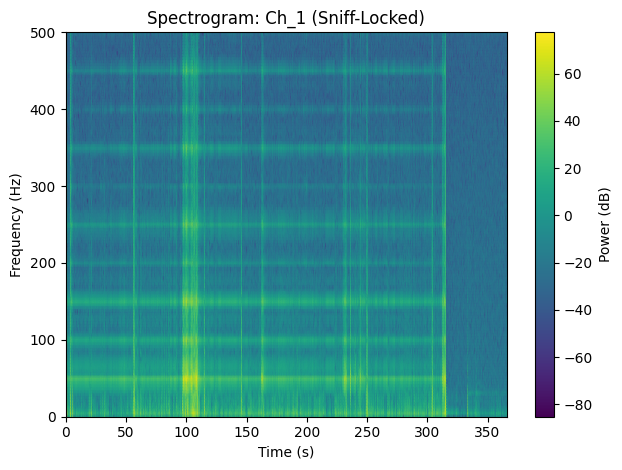

In [ ]:
ch = 'Ch_1'
f, t, Sxx = signal.spectrogram(raw_clean.get_data(picks=[ch])[0], fs=sfreq, nperseg=256)
plt.pcolormesh(t-0.2, f, 10 * np.log10(Sxx), shading='gouraud')
plt.axvline(0, color='r', linestyle='--')
plt.ylabel('Frequency (Hz)'); plt.xlabel('Time (s)')
plt.title(f'Spectrogram: {ch} (Sniff-Locked)')
plt.colorbar(label='Power (dB)'); plt.tight_layout()
plt.show()


See clustering/separability of sniff vs non-sniff windows.

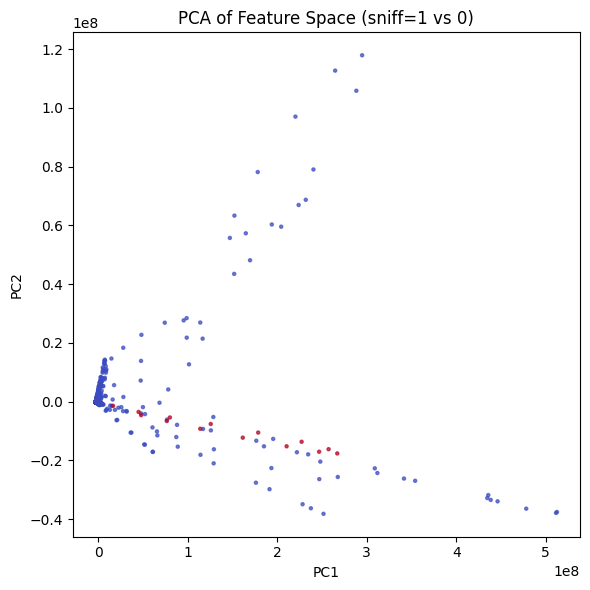

In [ ]:
from sklearn.decomposition import PCA
proj = PCA(n_components=2).fit_transform(X)
plt.figure(figsize=(6,6))
plt.scatter(proj[:,0], proj[:,1], c=y, s=5, cmap='coolwarm', alpha=0.7)
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('PCA of Feature Space (sniff=1 vs 0)')
plt.tight_layout(); plt.show()


Compare, say, delta-band power in sniff vs non-sniff.

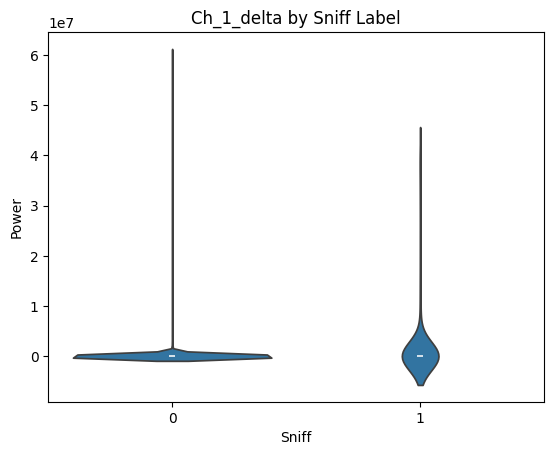

In [ ]:
feat = 'Ch_1_delta'
sns.violinplot(x=y, y=X[feat]) # Replace labels_window with y
plt.title(f'{feat} by Sniff Label'); plt.xlabel('Sniff'); plt.ylabel('Power'); plt.show()

Show training vs validation performance as you grow data or epochs.


In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, val_scores = learning_curve(
    xgb, X_train_bal, y_train_bal, cv=5, scoring='f1', n_jobs=-1)
# then plot mean±std of train_scores & val_scores vs train_sizes


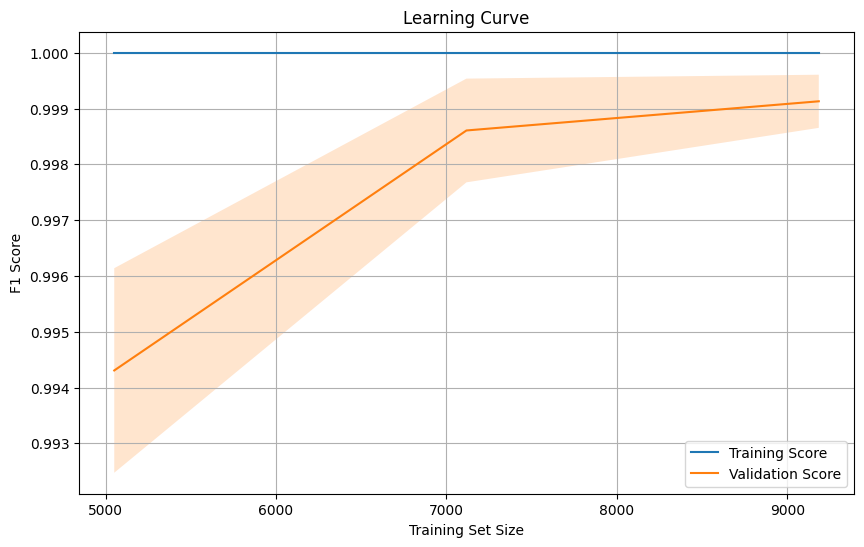

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.2)

plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Score')
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.2)

plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()


ROC & Precision-Recall Curves

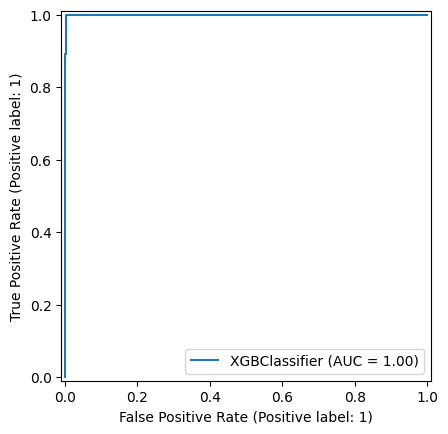

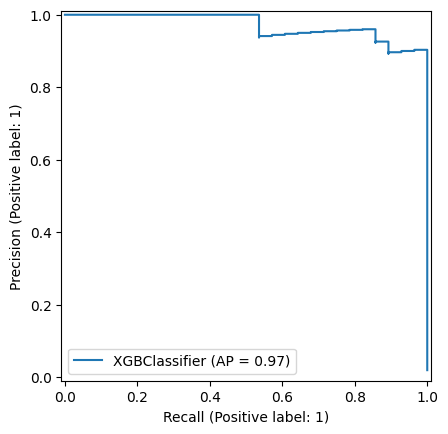

In [ ]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
RocCurveDisplay.from_estimator(xgb, X_test, y_test); plt.show()
PrecisionRecallDisplay.from_estimator(xgb, X_test, y_test); plt.show()


Feature Importance Bar PLot

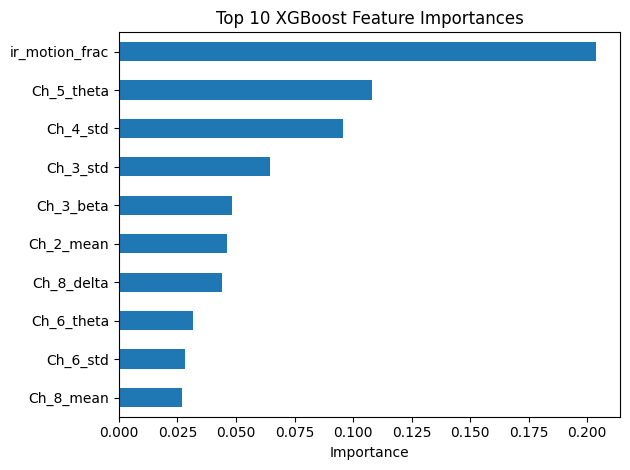

In [ ]:
imp = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=True)
imp.tail(10).plot.barh()
plt.title('Top 10 XGBoost Feature Importances'); plt.xlabel('Importance'); plt.tight_layout()
plt.show()
